In [141]:
import numpy as np
import librosa
import scipy.fftpack as fft

In [15]:
n_fft = 2048
pad_mode = 'reflect'

y = librosa.load('spoken_command_example.wav')
y = range(100)
y_centered = np.pad(y, 10, mode=pad_mode)

print(y_centered, len(y_centered))

[10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9 10 11 12 13
 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85
 86 87 88 89 90 91 92 93 94 95 96 97 98 99 98 97 96 95 94 93 92 91 90 89] 120


In [ ]:
"""The code I'm porting."""

def melspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512,
                   power=2.0, **kwargs):
    
    S, n_fft = _spectrogram(y=y, S=S, n_fft=n_fft, hop_length=hop_length,
                            power=power)

    # Build a Mel filter
    mel_basis = filters.mel(sr, n_fft, **kwargs)

    return np.dot(mel_basis, S)

def _spectrogram(y=None, S=None, n_fft=2048, hop_length=512, power=1):

    if S is not None:
        # Infer n_fft from spectrogram shape
        n_fft = 2 * (S.shape[0] - 1)
    else:
        # Otherwise, compute a magnitude spectrogram from input
        S = np.abs(stft(y, n_fft=n_fft, hop_length=hop_length))**power

    return S, n_fft

def stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann',
         center=True, dtype=np.complex64, pad_mode='reflect'):
    

    # By default, use the entire frame
    if win_length is None:
        win_length = n_fft

    # Set the default hop, if it's not already specified
    if hop_length is None:
        hop_length = int(win_length // 4)

    fft_window = get_window(window, win_length, fftbins=True)

    # Pad the window out to n_fft size
    fft_window = util.pad_center(fft_window, n_fft)

    # Reshape so that the window can be broadcast
    fft_window = fft_window.reshape((-1, 1))

    # Check audio is valid
    util.valid_audio(y)

    # Pad the time series so that frames are centered
    if center:
        y = np.pad(y, int(n_fft // 2), mode=pad_mode)

    # Window the time series.
    y_frames = util.frame(y, frame_length=n_fft, hop_length=hop_length)

    # Pre-allocate the STFT matrix
    stft_matrix = np.empty((int(1 + n_fft // 2), y_frames.shape[1]),
                           dtype=dtype,
                           order='F')

    # how many columns can we fit within MAX_MEM_BLOCK?
    n_columns = int(util.MAX_MEM_BLOCK / (stft_matrix.shape[0] *
                                          stft_matrix.itemsize))

    for bl_s in range(0, stft_matrix.shape[1], n_columns):
        bl_t = min(bl_s + n_columns, stft_matrix.shape[1])

        # RFFT and Conjugate here to match phase from DPWE code
        stft_matrix[:, bl_s:bl_t] = fft.fft(fft_window *
                                            y_frames[:, bl_s:bl_t],
                                            axis=0)[:stft_matrix.shape[0]]

    return stft_matrix


def mel(sr, n_fft, n_mels=128, fmin=0.0, fmax=None, htk=False,
        norm=1):
    
    if fmax is None:
        fmax = float(sr) / 2

    if norm is not None and norm != 1 and norm != np.inf:
        raise ParameterError('Unsupported norm: {}'.format(repr(norm)))

    # Initialize the weights
    n_mels = int(n_mels)
    weights = np.zeros((n_mels, int(1 + n_fft // 2)))

    # Center freqs of each FFT bin
    fftfreqs = fft_frequencies(sr=sr, n_fft=n_fft)

    # 'Center freqs' of mel bands - uniformly spaced between limits
    mel_f = mel_frequencies(n_mels + 2, fmin=fmin, fmax=fmax, htk=htk)

    fdiff = np.diff(mel_f)
    ramps = np.subtract.outer(mel_f, fftfreqs)

    for i in range(n_mels):
        # lower and upper slopes for all bins
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i+2] / fdiff[i+1]

        # .. then intersect them with each other and zero
        weights[i] = np.maximum(0, np.minimum(lower, upper))

    if norm == 1:
        # Slaney-style mel is scaled to be approx constant energy per channel
        enorm = 2.0 / (mel_f[2:n_mels+2] - mel_f[:n_mels])
        weights *= enorm[:, np.newaxis]

    # Only check weights if f_mel[0] is positive
    if not np.all((mel_f[:-2] == 0) | (weights.max(axis=1) > 0)):
        # This means we have an empty channel somewhere
        warnings.warn('Empty filters detected in mel frequency basis. '
                      'Some channels will produce empty responses. '
                      'Try increasing your sampling rate (and fmax) or '
                      'reducing n_mels.')

    return weights


In [18]:
a = [1, 2, 3, 4, 5]
np.pad(a, 2, 'reflect')
[ 3, 2, 1, 2, 3, 4, 5, 4, 3 ]
[ 3, 2, 1, 2, 3, 4, 5, 4, 3 ]

array([3, 2, 1, 2, 3, 4, 5, 4, 3])

In [65]:
a = np.array(range(6))
librosa.util.pad_center(a, 10)

array([0, 0, 0, 1, 2, 3, 4, 5, 0, 0])

In [69]:
a = np.array(range(104))
librosa.util.frame(a, frame_length=10, hop_length=5).T

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [45, 46, 47, 48, 49, 50, 51, 52, 53, 54],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [55, 56, 57, 58, 59, 60, 61, 62, 63, 64],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [65, 66, 67, 68, 69, 70, 71, 72, 73, 74],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [75, 76, 77, 78, 79, 80, 81, 82, 83, 84],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [85, 86, 87, 88, 89, 90, 91, 92, 93, 94],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [60]:
y = np.array([0, 1, 0, 0])
fft_vals = fft.fft(y)
fft_mags = np.abs(fft_vals)
print(fft_vals)

[ 1.+0.j  0.-1.j -1.+0.j  0.+1.j]


In [131]:
y, sr = librosa.load('spoken_command_example.wav', sr=16000)
y = y[-2048:]

# print(range(1000)[-10:])

print(len(y))
Y = fft.fft(y)
mags = np.abs(Y)
print(','.join([str(mag) for mag in mags[-10:]]))

2048
0.37909225,0.39151394,2.0663054,0.86155003,0.7584111,0.6130846,0.5864627,0.37788,0.23760916,0.6239957


In [145]:
# Generate FFT magnitudes
y, sr = librosa.load('../test/test.wav', sr=16000)
y = y[:2048]
fft_vals = fft.fft(y)
fft_mags = np.abs(fft_vals)
print(len(fft_mags))

np.savetxt('../test/fft_mags_2048.txt', fft_mags)

2048


In [149]:
# Generate Hann window magnitudes
from scipy import signal
win_length = 256
n_fft = 256

fft_window = signal.get_window('hann', win_length, fftbins=True)

# Pad the window out to n_fft size
fft_window = librosa.util.pad_center(fft_window, n_fft)

np.savetxt('../test/fft_window_256.txt', fft_window)

In [136]:
# Generate STFT Magnitudes
y, sr = librosa.load('../test/test.wav', sr=16000)
print(len(y), sr)
stft = np.abs(librosa.stft(y))

np.savetxt('../test/stft_mags.txt', stft)

3050 16000


In [166]:
# Generate MEL Magnitudes
SAMPLE_RATE = 16000
HOP_LENGTH = 512
F_MIN = 500
N_MELS = 229

y, sr = librosa.load('../test/test.wav', sr=16000)
mel = librosa.feature.melspectrogram(
  y,
  SAMPLE_RATE,
  hop_length=HOP_LENGTH,
  fmin=F_MIN,
  n_mels=N_MELS).astype(np.float32)

np.savetxt('../test/mel_mags.txt', mel)

(229, 1025)


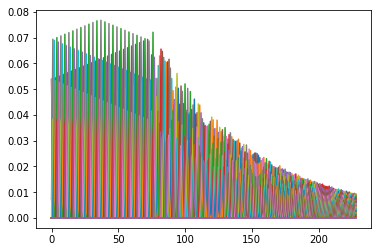

In [167]:
import matplotlib.pyplot as plt

# Build a Mel filter
mel_basis = librosa.filters.mel(16000, 2048, n_mels=229, fmin=30)
print(mel_basis.shape)

plt.plot(mel_basis)
plt.show()

np.savetxt('../test/mel_filter.txt', mel_basis)

max diff 0.00942140817642212


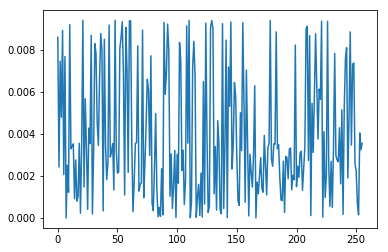

In [163]:
# FFT diffing.

green={"0":0,"1":0.00015177401655819267,"2":0.0006070039235055447,"3":0.0013654133072122931,"4":0.0024265418760478497,"5":0.003789745271205902,"6":0.005454195663332939,"7":0.007418883498758078,"8":0.009682614356279373,"9":0.01224401593208313,"10":0.015101531520485878,"11":0.018253426998853683,"12":0.021697789430618286,"13":0.0254325270652771,"14":0.02945537306368351,"15":0.033763885498046875,"16":0.038355447351932526,"17":0.04322727024555206,"18":0.04837640002369881,"19":0.05379970744252205,"20":0.05949390307068825,"21":0.06545552611351013,"22":0.0716809630393982,"23":0.0781664252281189,"24":0.08490798622369766,"25":0.09190154075622559,"26":0.09914285689592361,"27":0.10662753134965897,"28":0.11435101926326752,"29":0.1223086342215538,"30":0.13049554824829102,"31":0.13890677690505981,"32":0.1475372314453125,"33":0.15638165175914764,"34":0.16543470323085785,"35":0.174690842628479,"36":0.1841444969177246,"37":0.19378989934921265,"38":0.20362119376659393,"39":0.21363243460655212,"40":0.22381751239299774,"41":0.23417027294635773,"42":0.2446843981742859,"43":0.25535354018211365,"44":0.2661712169647217,"45":0.2771308124065399,"46":0.2882257401943207,"47":0.29944923520088196,"48":0.310794472694397,"49":0.32225459814071655,"50":0.3338226079940796,"51":0.345491498708725,"52":0.3572542071342468,"53":0.3691035807132721,"54":0.38103240728378296,"55":0.3930334448814392,"56":0.40509945154190063,"57":0.4172230660915375,"58":0.42939692735671997,"59":0.44161364436149597,"60":0.45386582612991333,"61":0.46614599227905273,"62":0.47844672203063965,"63":0.49076053500175476,"64":0.5030799508094788,"65":0.5153975486755371,"66":0.527705729007721,"67":0.5399971008300781,"68":0.5522642135620117,"69":0.5644996166229248,"70":0.5766957998275757,"71":0.5888454914093018,"72":0.6009411811828613,"73":0.6129756569862366,"74":0.6249414682388306,"75":0.636831521987915,"76":0.6486384272575378,"77":0.6603550910949707,"78":0.6719744801521301,"79":0.6834893822669983,"80":0.694892942905426,"81":0.7061781883239746,"82":0.7173382043838501,"83":0.7283663153648376,"84":0.7392557859420776,"85":0.75,"86":0.7605924606323242,"87":0.7710266709327698,"88":0.7812963724136353,"89":0.7913953065872192,"90":0.8013173341751099,"91":0.8110564351081848,"92":0.8206066489219666,"93":0.8299622535705566,"94":0.8391175866127014,"95":0.8480669856071472,"96":0.8568050861358643,"97":0.8653265833854675,"98":0.8736262917518616,"99":0.8816991448402405,"100":0.8895403146743774,"101":0.8971449732780457,"102":0.9045084714889526,"103":0.9116264581680298,"104":0.9184945821762085,"105":0.9251085519790649,"106":0.9314644932746887,"107":0.9375584721565247,"108":0.9433868527412415,"109":0.9489459991455078,"110":0.9542326331138611,"111":0.9592434763908386,"112":0.9639755487442017,"113":0.9684259295463562,"114":0.9725919365882874,"115":0.9764710068702698,"116":0.9800608158111572,"117":0.9833592176437378,"118":0.9863641262054443,"119":0.9890738129615784,"120":0.9914865493774414,"121":0.9936009049415588,"122":0.9954156279563904,"123":0.9969295859336853,"124":0.9981418251991272,"125":0.9990516901016235,"126":0.9996585249900818,"127":0.9999620318412781,"128":0.9999620318412781,"129":0.9996585249900818,"130":0.9990516901016235,"131":0.9981418251991272,"132":0.9969295859336853,"133":0.9954156279563904,"134":0.9936009049415588,"135":0.9914865493774414,"136":0.9890738129615784,"137":0.9863641262054443,"138":0.9833592176437378,"139":0.9800608158111572,"140":0.9764710068702698,"141":0.9725919365882874,"142":0.9684259295463562,"143":0.9639755487442017,"144":0.9592434763908386,"145":0.9542326331138611,"146":0.9489459991455078,"147":0.9433868527412415,"148":0.9375584721565247,"149":0.9314644932746887,"150":0.9251085519790649,"151":0.9184945821762085,"152":0.9116264581680298,"153":0.9045084714889526,"154":0.8971449732780457,"155":0.8895403146743774,"156":0.8816991448402405,"157":0.8736262917518616,"158":0.8653265833854675,"159":0.8568050861358643,"160":0.8480669856071472,"161":0.8391175866127014,"162":0.8299622535705566,"163":0.8206066489219666,"164":0.8110564351081848,"165":0.8013173341751099,"166":0.7913953065872192,"167":0.7812963724136353,"168":0.7710266709327698,"169":0.7605924606323242,"170":0.75,"171":0.7392557859420776,"172":0.7283663153648376,"173":0.7173382043838501,"174":0.7061781883239746,"175":0.694892942905426,"176":0.6834893822669983,"177":0.6719744801521301,"178":0.6603550910949707,"179":0.6486384272575378,"180":0.636831521987915,"181":0.6249414682388306,"182":0.6129756569862366,"183":0.6009411811828613,"184":0.5888454914093018,"185":0.5766957998275757,"186":0.5644996166229248,"187":0.5522642135620117,"188":0.5399971008300781,"189":0.527705729007721,"190":0.5153975486755371,"191":0.5030799508094788,"192":0.49076053500175476,"193":0.47844672203063965,"194":0.46614599227905273,"195":0.45386582612991333,"196":0.44161364436149597,"197":0.42939692735671997,"198":0.4172230660915375,"199":0.40509945154190063,"200":0.3930334448814392,"201":0.38103240728378296,"202":0.3691035807132721,"203":0.3572542071342468,"204":0.345491498708725,"205":0.3338226079940796,"206":0.32225459814071655,"207":0.310794472694397,"208":0.29944923520088196,"209":0.2882257401943207,"210":0.2771308124065399,"211":0.2661712169647217,"212":0.25535354018211365,"213":0.2446843981742859,"214":0.23417027294635773,"215":0.22381751239299774,"216":0.21363243460655212,"217":0.20362119376659393,"218":0.19378989934921265,"219":0.1841444969177246,"220":0.174690842628479,"221":0.16543470323085785,"222":0.15638165175914764,"223":0.1475372314453125,"224":0.13890677690505981,"225":0.13049554824829102,"226":0.1223086342215538,"227":0.11435101926326752,"228":0.10662753134965897,"229":0.09914285689592361,"230":0.09190154075622559,"231":0.08490798622369766,"232":0.0781664252281189,"233":0.0716809630393982,"234":0.06545552611351013,"235":0.05949390307068825,"236":0.05379970744252205,"237":0.04837640002369881,"238":0.04322727024555206,"239":0.038355447351932526,"240":0.033763885498046875,"241":0.02945537306368351,"242":0.0254325270652771,"243":0.021697789430618286,"244":0.018253426998853683,"245":0.015101531520485878,"246":0.01224401593208313,"247":0.009682614356279373,"248":0.007418883498758078,"249":0.005454195663332939,"250":0.003789745271205902,"251":0.0024265418760478497,"252":0.0013654133072122931,"253":0.0006070039235055447,"254":0.00015177401655819267,"255":0}
red={"0":0,"1":0.00015059065481182188,"2":0.0006022718735039234,"3":0.0013547716662287712,"4":0.0024076367262750864,"5":0.003760232590138912,"6":0.005411745049059391,"7":0.007361178752034903,"8":0.009607359766960144,"9":0.012148935347795486,"10":0.0149843730032444,"11":0.01811196655035019,"12":0.02152983285486698,"13":0.025235909968614578,"14":0.02922796830534935,"15":0.03350359946489334,"16":0.03806023299694061,"17":0.0428951233625412,"18":0.0480053536593914,"19":0.053387850522994995,"20":0.059039369225502014,"21":0.06495650112628937,"22":0.07113569229841232,"23":0.07757321745157242,"24":0.08426519483327866,"25":0.0912075936794281,"26":0.09839623421430588,"27":0.10582678765058517,"28":0.11349477618932724,"29":0.12139558047056198,"30":0.12952443957328796,"31":0.1378764659166336,"32":0.1464466154575348,"33":0.15522973239421844,"34":0.16422052681446075,"35":0.17341357469558716,"36":0.18280336260795593,"37":0.19238419830799103,"38":0.2021503448486328,"39":0.21209590137004852,"40":0.22221487760543823,"41":0.23250119388103485,"42":0.24294862151145935,"43":0.2535509169101715,"44":0.2643016278743744,"45":0.27519434690475464,"46":0.2862224578857422,"47":0.29737934470176697,"48":0.30865827202796936,"49":0.32005247473716736,"50":0.3315550684928894,"51":0.34315913915634155,"52":0.3548576533794403,"53":0.36664360761642456,"54":0.37850990891456604,"55":0.3904493749141693,"56":0.40245485305786133,"57":0.4145190417766571,"58":0.4266347587108612,"59":0.43879467248916626,"60":0.4509914219379425,"61":0.46321770548820496,"62":0.47546616196632385,"63":0.48772940039634705,"64":0.5,"65":0.5122706294059753,"66":0.5245338082313538,"67":0.5367822647094727,"68":0.5490085482597351,"69":0.5612053275108337,"70":0.5733652114868164,"71":0.5854809284210205,"72":0.5975451469421387,"73":0.6095505952835083,"74":0.6214900612831116,"75":0.6333563923835754,"76":0.6451423168182373,"77":0.6568408608436584,"78":0.6684449315071106,"79":0.6799474954605103,"80":0.6913416981697083,"81":0.7026206851005554,"82":0.7137775421142578,"83":0.7248056530952454,"84":0.7356983423233032,"85":0.7464491128921509,"86":0.7570513486862183,"87":0.767498791217804,"88":0.7777851223945618,"89":0.7879040837287903,"90":0.7978496551513672,"91":0.8076158165931702,"92":0.8171966671943665,"93":0.8265864253044128,"94":0.8357794880867004,"95":0.8447702527046204,"96":0.8535534143447876,"97":0.8621235489845276,"98":0.8704755902290344,"99":0.8786044120788574,"100":0.8865052461624146,"101":0.8941732048988342,"102":0.9016037583351135,"103":0.9087924361228943,"104":0.9157348275184631,"105":0.9224267601966858,"106":0.9288643002510071,"107":0.9350435137748718,"108":0.9409606456756592,"109":0.9466121792793274,"110":0.9519946575164795,"111":0.9571048617362976,"112":0.9619397521018982,"113":0.9664964079856873,"114":0.9707720279693604,"115":0.9747641086578369,"116":0.9784701466560364,"117":0.9818880558013916,"118":0.9850156307220459,"119":0.987851083278656,"120":0.9903926253318787,"121":0.9926388263702393,"122":0.9945882558822632,"123":0.9962397813796997,"124":0.9975923895835876,"125":0.9986452460289001,"126":0.9993977546691895,"127":0.9998494386672974,"128":1,"129":0.9998494386672974,"130":0.9993977546691895,"131":0.9986452460289001,"132":0.9975923895835876,"133":0.9962397813796997,"134":0.9945882558822632,"135":0.9926388263702393,"136":0.9903926253318787,"137":0.987851083278656,"138":0.9850156307220459,"139":0.9818880558013916,"140":0.9784701466560364,"141":0.9747641086578369,"142":0.9707720279693604,"143":0.9664964079856873,"144":0.9619397521018982,"145":0.9571048617362976,"146":0.9519946575164795,"147":0.9466121792793274,"148":0.9409606456756592,"149":0.9350435137748718,"150":0.9288643002510071,"151":0.9224267601966858,"152":0.9157348275184631,"153":0.9087924361228943,"154":0.9016037583351135,"155":0.8941732048988342,"156":0.8865052461624146,"157":0.8786044120788574,"158":0.8704755902290344,"159":0.8621235489845276,"160":0.8535534143447876,"161":0.8447702527046204,"162":0.8357794880867004,"163":0.8265864253044128,"164":0.8171966671943665,"165":0.8076158165931702,"166":0.7978496551513672,"167":0.7879040837287903,"168":0.7777851223945618,"169":0.767498791217804,"170":0.7570513486862183,"171":0.7464491128921509,"172":0.7356983423233032,"173":0.7248056530952454,"174":0.7137775421142578,"175":0.7026206851005554,"176":0.6913416981697083,"177":0.6799474954605103,"178":0.6684449315071106,"179":0.6568408608436584,"180":0.6451423168182373,"181":0.6333563923835754,"182":0.6214900612831116,"183":0.6095505952835083,"184":0.5975451469421387,"185":0.5854809284210205,"186":0.5733652114868164,"187":0.5612053275108337,"188":0.5490085482597351,"189":0.5367822647094727,"190":0.5245338082313538,"191":0.5122706294059753,"192":0.5,"193":0.48772940039634705,"194":0.47546616196632385,"195":0.46321770548820496,"196":0.4509914219379425,"197":0.43879467248916626,"198":0.4266347587108612,"199":0.4145190417766571,"200":0.40245485305786133,"201":0.3904493749141693,"202":0.37850990891456604,"203":0.36664360761642456,"204":0.3548576533794403,"205":0.34315913915634155,"206":0.3315550684928894,"207":0.32005247473716736,"208":0.30865827202796936,"209":0.29737934470176697,"210":0.2862224578857422,"211":0.27519434690475464,"212":0.2643016278743744,"213":0.2535509169101715,"214":0.24294862151145935,"215":0.23250119388103485,"216":0.22221487760543823,"217":0.21209590137004852,"218":0.2021503448486328,"219":0.19238419830799103,"220":0.18280336260795593,"221":0.17341357469558716,"222":0.16422052681446075,"223":0.15522973239421844,"224":0.1464466154575348,"225":0.1378764659166336,"226":0.12952443957328796,"227":0.12139558047056198,"228":0.11349477618932724,"229":0.10582678765058517,"230":0.09839623421430588,"231":0.0912075936794281,"232":0.08426519483327866,"233":0.07757321745157242,"234":0.07113569229841232,"235":0.06495650112628937,"236":0.059039369225502014,"237":0.053387850522994995,"238":0.0480053536593914,"239":0.0428951233625412,"240":0.03806023299694061,"241":0.03350359946489334,"242":0.02922796830534935,"243":0.025235909968614578,"244":0.02152983285486698,"245":0.01811196655035019,"246":0.0149843730032444,"247":0.012148935347795486,"248":0.009607359766960144,"249":0.007361178752034903,"250":0.005411745049059391,"251":0.003760232590138912,"252":0.0024076367262750864,"253":0.0013547716662287712,"254":0.0006022718735039234,"255":0.00015059065481182188}

green = np.array(list(green.values()))
red = np.array(list(red.values()))
diff = green - red

print('max diff', np.max(np.abs(diff)))


plt.plot(np.abs(diff))
plt.show()
